# ResNeXt
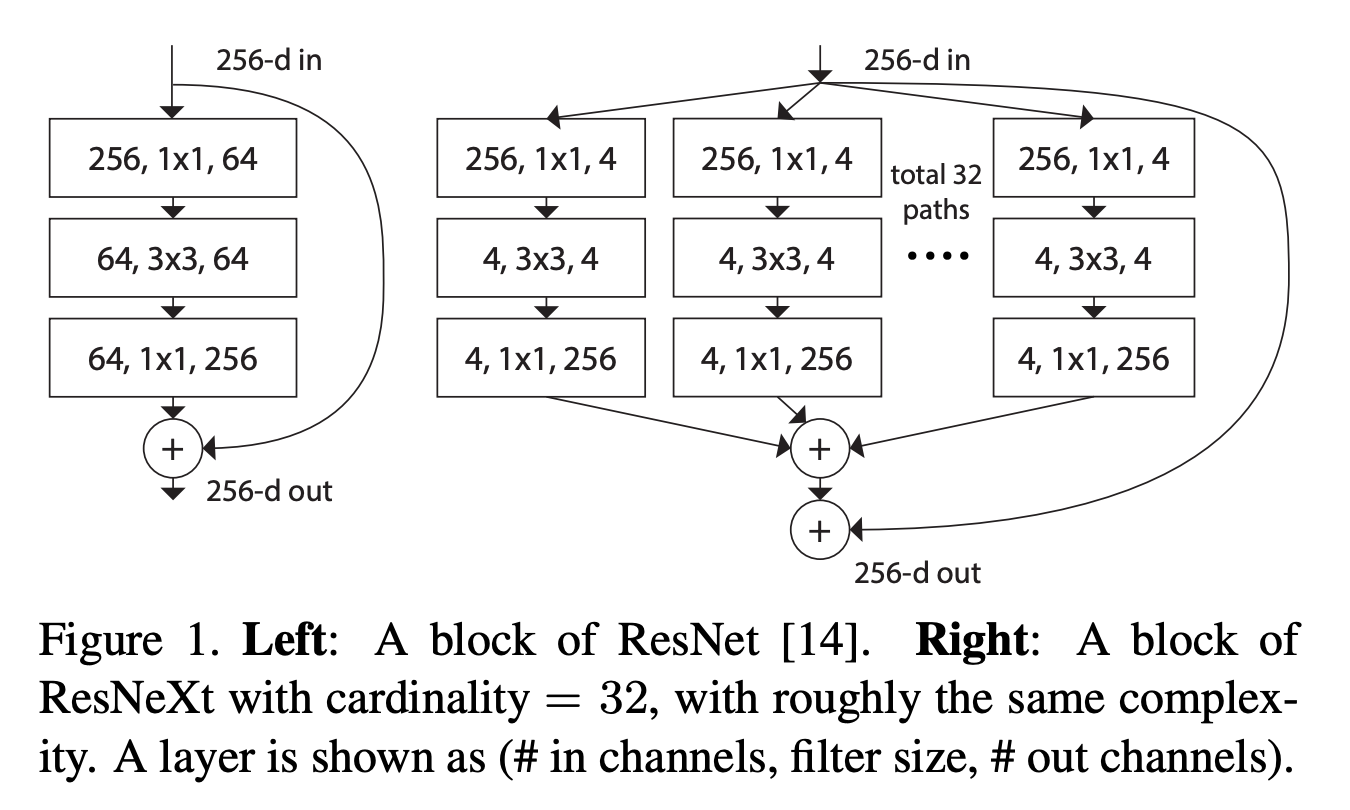
Simple, really simple ResNet improvement.<br>
Nah it's actually simple. They just use grouped convolutions running in parallel.<br>
Simple as that!
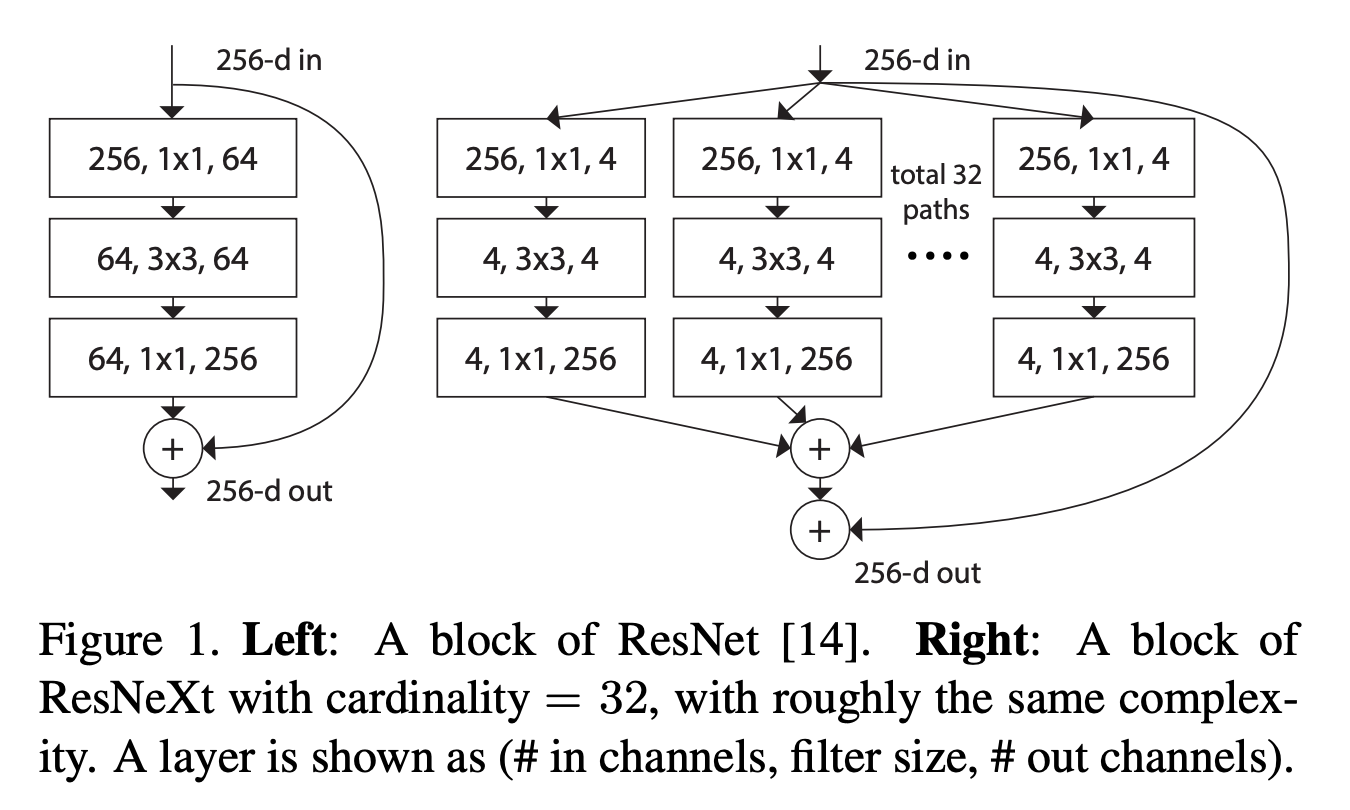

# Part I. Data

In [3]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, RandomSampler
from torchinfo import summary
from torch.optim.lr_scheduler import StepLR

import matplotlib.pyplot as plt
import os
import numpy as np

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
data_transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.RandomCrop((224, 224)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5071, 0.4867, 0.4408],
        std=[0.2675, 0.2565, 0.2761]
    )
])

In [6]:
train_dataset = datasets.CIFAR100("./data", train=True, download=True, transform=data_transform)
val_dataset = datasets.CIFAR100("./data", train=True, download=True, transform=data_transform)
test_dataset = datasets.CIFAR100("./data", train=False, download=True, transform=data_transform)

train_dataset, val_dataset, test_dataset

100%|██████████| 169M/169M [00:52<00:00, 3.19MB/s] 


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


(Dataset CIFAR100
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                Resize(size=(227, 227), interpolation=bilinear, max_size=None, antialias=True)
                RandomCrop(size=(224, 224), padding=None)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
                Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
            ),
 Dataset CIFAR100
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                Resize(size=(227, 227), interpolation=bilinear, max_size=None, antialias=True)
                RandomCrop(size=(224, 224), padding=None)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
                Normalize(mean=[0.5071

In [7]:
m_samples = len(train_dataset)
indices = np.arange(m_samples)
np.random.shuffle(indices)

train_ratio = 0.8
train_indices = indices[:int(m_samples * train_ratio)]
val_indices = indices[int(m_samples * train_ratio):]

train_sampler = RandomSampler(train_indices)
val_sampler = RandomSampler(val_indices)

In [8]:
train_dataloader = DataLoader(train_dataset,
                              batch_size=128,
                              pin_memory=True,
                              num_workers=os.cpu_count(),
                              sampler=train_sampler)

val_dataloader = DataLoader(val_dataset,
                            batch_size=128,
                            pin_memory=True,
                            num_workers=os.cpu_count(),
                            sampler=val_sampler)

test_dataloader = DataLoader(test_dataset,
                            batch_size=128,
                            pin_memory=True,
                            num_workers=os.cpu_count(),
                            sampler=val_sampler)

len(train_dataloader), len(val_dataloader), len(test_dataloader)

(313, 79, 79)

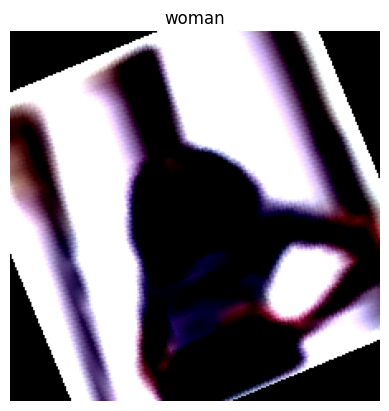

In [ ]:
for image_batch, label_batch in train_dataloader:
    image = image_batch[0]
    label = label_batch[0]

    plt.title(train_dataset.classes[label])
    plt.axis("off")
    plt.imshow(image.permute(1, 2, 0));
    break

## Part II. Architecture

In [16]:
class BottleNeckBlock(nn.Module):
    def __init__(self, input_channels, output_channels, stride=1, c=1):
        super().__init__()
        multiplier = 4
        final_channels = output_channels * multiplier
        identity_transform = (input_channels != output_channels * 4) or (stride != 1)

        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(input_channels, output_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(output_channels)
        # the ONLY difference
        self.conv2 = nn.Conv2d(output_channels, output_channels, kernel_size=3, stride=stride, padding=1, bias=False, groups=c)
        self.bn2 = nn.BatchNorm2d(output_channels)
        self.conv3 = nn.Conv2d(output_channels, output_channels*multiplier, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(output_channels*4)
        
        if identity_transform:
            self.downsample = nn.Sequential(
                nn.Conv2d(input_channels, output_channels * multiplier, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(output_channels * multiplier)
            )
        else:
            self.downsample = None

    def forward(self, x):
        identity = x
        f = self.conv1(x)
        f = self.bn1(f)
        f = self.relu(f)

        f = self.conv2(f)
        f = self.bn2(f)
        f = self.relu(f)

        f = self.conv3(f)
        f = self.bn3(f)

        if self.downsample is not None:
            identity = self.downsample(identity)

        out = f + identity
        out = self.relu(out)
        return out

In [17]:
class ResNeXt50(nn.Module):
    def __init__(self, input_channels=3, output_classes=100):
        super().__init__()
        self.input_size = 64

        self.ini_conv = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer_1 = self.make_layer(64, 3, stride=1, c=32)
        self.layer_2 = self.make_layer(128, 4, stride=2, c=32)
        self.layer_3 = self.make_layer(256, 6, stride=2, c=32)
        self.layer_4 = self.make_layer(512, 3, stride=2, c=32)
        # 512x1x1 output from AvgPool
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, output_classes)

    def make_layer(self, output_channels, no_blocks, stride, c):
        blocks = []
        blocks.append(BottleNeckBlock(self.input_size, output_channels, stride=stride, c=c))
        self.input_size = output_channels * 4

        for _ in range(1, no_blocks):
            blocks.append(BottleNeckBlock(self.input_size, output_channels, stride=1, c=c))

        return nn.Sequential(*blocks)

    def forward(self, x):
        out = self.ini_conv(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.layer_1(out)
        out = self.layer_2(out)
        out = self.layer_3(out)
        out = self.layer_4(out)
        out = self.avg_pool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)

        return out

In [18]:
resexy = ResNeXt50()

summary(resexy, input_size=(128, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNeXt50                                [128, 100]                --
├─Conv2d: 1-1                            [128, 64, 109, 109]       9,408
├─BatchNorm2d: 1-2                       [128, 64, 109, 109]       128
├─ReLU: 1-3                              [128, 64, 109, 109]       --
├─MaxPool2d: 1-4                         [128, 64, 55, 55]         --
├─Sequential: 1-5                        [128, 256, 55, 55]        --
│    └─BottleNeckBlock: 2-1              [128, 256, 55, 55]        --
│    │    └─Conv2d: 3-1                  [128, 64, 55, 55]         4,096
│    │    └─BatchNorm2d: 3-2             [128, 64, 55, 55]         128
│    │    └─ReLU: 3-3                    [128, 64, 55, 55]         --
│    │    └─Conv2d: 3-4                  [128, 64, 55, 55]         1,152
│    │    └─BatchNorm2d: 3-5             [128, 64, 55, 55]         128
│    │    └─ReLU: 3-6                    [128, 64, 55, 55]         --
│  

In [19]:
num_classes = 100
num_epochs = 20
learning_rate = 0.001

model = ResNeXt50(output_classes=num_classes).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=5, gamma=0.3)

total_step = len(train_dataloader)

In [20]:
train_step = len(train_dataloader)
val_step = len(val_dataloader)

for epoch in range(num_epochs):
    # Train step
    model.train()
    for i, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        outputs = torch.softmax(logits, dim=1).argmax(dim=1)
        loss = loss_fn(logits, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    scheduler.step()
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train| Step {i+1}/{train_step}, Loss: {loss.item():.4f}")

    # Validation step
    model.eval()
    with torch.inference_mode():
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(val_dataloader):
            images = images.to(device)
            labels = labels.to(device)
            logits = model(images)

            loss = loss_fn(logits, labels)
            
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, logits

        print(f"Val| Step {i+1}/{val_step}, Loss: {loss.item():.4f}, Accuracy: {100*correct/total:.4f}")
        print("="*60)

Epoch 1/20
Train| Step 313/313, Loss: 3.9063
Val| Step 79/79, Loss: 4.3708, Accuracy: 9.8200
Epoch 2/20
Train| Step 313/313, Loss: 3.2854
Val| Step 79/79, Loss: 2.8844, Accuracy: 17.1100
Epoch 3/20
Train| Step 313/313, Loss: 2.6734
Val| Step 79/79, Loss: 2.8873, Accuracy: 25.6300
Epoch 4/20
Train| Step 313/313, Loss: 2.8632
Val| Step 79/79, Loss: 3.1843, Accuracy: 33.5700
Epoch 5/20
Train| Step 313/313, Loss: 2.2030
Val| Step 79/79, Loss: 1.8192, Accuracy: 41.3200
Epoch 6/20
Train| Step 313/313, Loss: 1.8569
Val| Step 79/79, Loss: 1.6748, Accuracy: 50.5000
Epoch 7/20
Train| Step 313/313, Loss: 1.5057
Val| Step 79/79, Loss: 1.0536, Accuracy: 55.3800
Epoch 8/20
Train| Step 313/313, Loss: 1.6042
Val| Step 79/79, Loss: 1.3002, Accuracy: 55.7300
Epoch 9/20
Train| Step 313/313, Loss: 1.4324
Val| Step 79/79, Loss: 2.8296, Accuracy: 60.7100
Epoch 10/20
Train| Step 313/313, Loss: 1.4206
Val| Step 79/79, Loss: 1.9507, Accuracy: 62.6700
Epoch 11/20
Train| Step 313/313, Loss: 1.5284
Val| Step 79/7